# Project: Image Classification and Regression  

**Amine SADEQ - MVA/CentraleSupelec** 

This is the first assignment for the Deep Learning course, it's goal t is to learn how to implement simple image classification and regression in Keras. 

It's composed of four parts : 

-  A Simple classification

-  A More difficult classification Problem

-  A Regression Problem 

-  Image Denoising


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.utils import np_utils

Using TensorFlow backend.


These are the functions used to generate the different datasets.

In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
#         if i % 100 == 0:
#             print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    print('Done')
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
#         if i % 100 == 0:
#             print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    print('Done')
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



In [3]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y = to_categorical(Y_train)
print('The data shape is : {}'.format(X_train.shape))
print('The labels shape is : {}'.format(Y.shape))

Creating data:
Done
The data shape is : (300, 5184)
The labels shape is : (300, 3)


## Simple Classification

In this part, we'll be using a simple fully connected network to classify our images. (Logistic regression) 

### Using the SGD optimizer

In [4]:
model = Sequential()
model.add(Dense(3 , input_shape =(X_train.shape[1],) ,activation='softmax'))
optim = SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.fit(X_train, Y, epochs=100, batch_size=16,  verbose=1)

Epoch 1/100
300/300 [==============================] - 4s 13ms/step - loss: 1.0443 - acc: 0.4833
Epoch 2/100
300/300 [==============================] - 0s 336us/step - loss: 0.8343 - acc: 0.6767
Epoch 3/100
300/300 [==============================] - 0s 383us/step - loss: 0.7871 - acc: 0.7100
Epoch 4/100
300/300 [==============================] - 0s 343us/step - loss: 0.6948 - acc: 0.7467
Epoch 5/100
300/300 [==============================] - 0s 340us/step - loss: 0.6273 - acc: 0.7533
Epoch 6/100
300/300 [==============================] - 0s 346us/step - loss: 0.5912 - acc: 0.7767
Epoch 7/100
300/300 [==============================] - 0s 346us/step - loss: 0.5470 - acc: 0.7833
Epoch 8/100
300/300 [==============================] - 0s 383us/step - loss: 0.5296 - acc: 0.8233
Epoch 9/100
300/300 [==============================] - 0s 380us/step - loss: 0.4934 - acc: 0.8333
Epoch 10/100
300/300 [==============================] - 0s 356us/step - loss: 0.5143 - acc: 0.7900
Epoch 11/100
300/300

300/300 [==============================] - 0s 336us/step - loss: 0.1351 - acc: 0.9800
Epoch 84/100
300/300 [==============================] - 0s 333us/step - loss: 0.1358 - acc: 0.9867
Epoch 85/100
300/300 [==============================] - 0s 330us/step - loss: 0.1343 - acc: 0.9800
Epoch 86/100
300/300 [==============================] - 0s 320us/step - loss: 0.1318 - acc: 0.9867
Epoch 87/100
300/300 [==============================] - 0s 333us/step - loss: 0.1302 - acc: 0.9767
Epoch 88/100
300/300 [==============================] - 0s 330us/step - loss: 0.1334 - acc: 0.9833
Epoch 89/100
300/300 [==============================] - 0s 323us/step - loss: 0.1297 - acc: 0.9867
Epoch 90/100
300/300 [==============================] - 0s 380us/step - loss: 0.1300 - acc: 0.9867
Epoch 91/100
300/300 [==============================] - 0s 483us/step - loss: 0.1265 - acc: 0.9800
Epoch 92/100
300/300 [==============================] - 0s 470us/step - loss: 0.1289 - acc: 0.9767
Epoch 93/100
300/300 [=

In [5]:
label_toshape = {0 : 'Rectangle' , 1:'Disk', 2:'triangle'}

You can run this next cell multiple times to see the prediction on new data.

Creating data:
Done


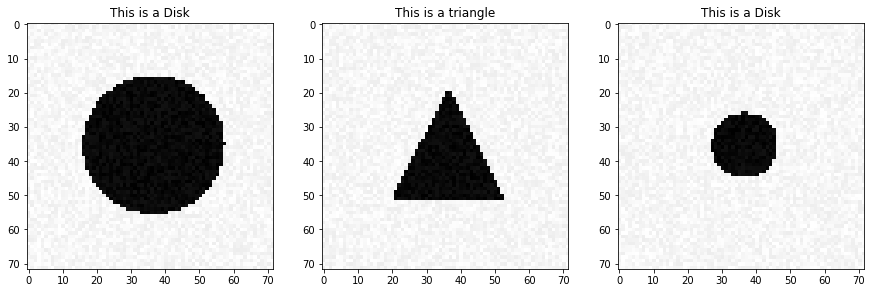

In [6]:
X_test, _ = generate_dataset_classification(3, 20)
X_test1 = X_test[0].reshape(1, X_test.shape[1])
X_test2 = X_test[1].reshape(1, X_test.shape[1])
X_test3 = X_test[2].reshape(1, X_test.shape[1])

Y1 = model.predict(X_test1)
Y2 = model.predict(X_test2)
Y3 = model.predict(X_test3) 

plt.figure(figsize=((15,5)))
plt.subplot(1,3,1)
plt.imshow(X_test1.reshape((int(np.sqrt(X_test1.shape[1])),int(np.sqrt(X_test1.shape[1])) )),cmap='gray')
plt.title('This is a {}'.format(label_toshape[np.argmax(Y1)] ))
plt.subplot(1,3,2)
plt.imshow(X_test2.reshape((int(np.sqrt(X_test2.shape[1])), int(np.sqrt(X_test2.shape[1])) )),cmap='gray')
plt.title('This is a {}'.format(label_toshape[np.argmax(Y2)] ))
plt.subplot(1,3,3)
plt.imshow(X_test3.reshape((int(np.sqrt(X_test3.shape[1])),int(np.sqrt(X_test3.shape[1])) )),cmap='gray')
plt.title('This is a {}'.format(label_toshape[np.argmax(Y3)] ))
plt.show()

## Visualization of the Solution

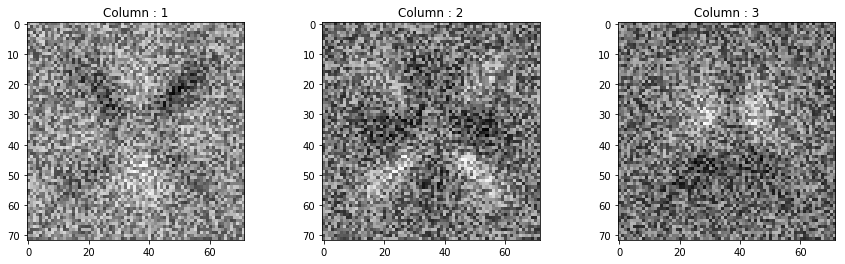

In [7]:
beta = model.get_weights()[0]
plt.figure(figsize=(15,4))
for i in range(beta.shape[1]) : 
    plt.subplot(1,3,i+1)
    plt.imshow(beta[:,i].reshape(( int(np.sqrt(beta.shape[0])), int(np.sqrt(beta.shape[0])) )),cmap='gray')
    plt.title('Column : {}'.format(i+1))

### Using the Adam optimizer

In [8]:
model = Sequential()
model.add(Dense(3 , input_shape =(X_train.shape[1],) ,activation='softmax'))
optim = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
model.fit(X_train, Y, epochs=100, batch_size=16,  verbose=1)


Epoch 1/100
300/300 [==============================] - 0s 1ms/step - loss: 1.7678 - acc: 0.4033
Epoch 2/100
300/300 [==============================] - 0s 450us/step - loss: 0.9878 - acc: 0.5833
Epoch 3/100
300/300 [==============================] - 0s 406us/step - loss: 0.5267 - acc: 0.7833
Epoch 4/100
300/300 [==============================] - 0s 416us/step - loss: 0.3341 - acc: 0.8433
Epoch 5/100
300/300 [==============================] - 0s 436us/step - loss: 0.2289 - acc: 0.9467
Epoch 6/100
300/300 [==============================] - 0s 380us/step - loss: 0.2110 - acc: 0.9500
Epoch 7/100
300/300 [==============================] - 0s 406us/step - loss: 0.1741 - acc: 0.9833
Epoch 8/100
300/300 [==============================] - 0s 456us/step - loss: 0.1957 - acc: 0.9300
Epoch 9/100
300/300 [==============================] - 0s 443us/step - loss: 0.2092 - acc: 0.9333
Epoch 10/100
300/300 [==============================] - 0s 416us/step - loss: 0.1418 - acc: 0.9633
Epoch 11/100
300/300 

300/300 [==============================] - 0s 383us/step - loss: 0.0055 - acc: 1.0000
Epoch 84/100
300/300 [==============================] - 0s 473us/step - loss: 0.0057 - acc: 1.0000
Epoch 85/100
300/300 [==============================] - 0s 550us/step - loss: 0.0056 - acc: 1.0000
Epoch 86/100
300/300 [==============================] - 0s 403us/step - loss: 0.0048 - acc: 1.0000
Epoch 87/100
300/300 [==============================] - 0s 370us/step - loss: 0.0049 - acc: 1.0000
Epoch 88/100
300/300 [==============================] - 0s 360us/step - loss: 0.0051 - acc: 1.0000
Epoch 89/100
300/300 [==============================] - 0s 373us/step - loss: 0.0045 - acc: 1.0000
Epoch 90/100
300/300 [==============================] - 0s 363us/step - loss: 0.0044 - acc: 1.0000
Epoch 91/100
300/300 [==============================] - 0s 366us/step - loss: 0.0041 - acc: 1.0000
Epoch 92/100
300/300 [==============================] - 0s 390us/step - loss: 0.0041 - acc: 1.0000
Epoch 93/100
300/300 [=

You can run this next cell multiple times to see the prediction on new data.

Creating data:
Done


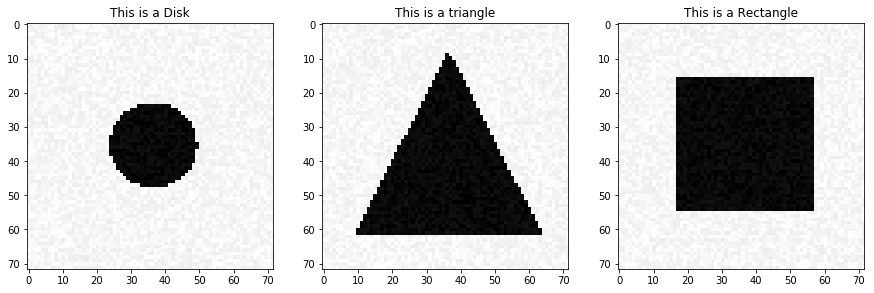

In [9]:
X_test, _ = generate_dataset_classification(3, 20)
X_test1 = X_test[0].reshape(1, X_test.shape[1])
X_test2 = X_test[1].reshape(1, X_test.shape[1])
X_test3 = X_test[2].reshape(1, X_test.shape[1])

Y1 = model.predict(X_test1)
Y2 = model.predict(X_test2)
Y3 = model.predict(X_test3) 

plt.figure(figsize=((15,5)))
plt.subplot(1,3,1)
plt.imshow(X_test1.reshape((int(np.sqrt(X_test1.shape[1])),int(np.sqrt(X_test1.shape[1])) )),cmap='gray')
plt.title('This is a {}'.format(label_toshape[np.argmax(Y1)] ))
plt.subplot(1,3,2)
plt.imshow(X_test2.reshape((int(np.sqrt(X_test2.shape[1])), int(np.sqrt(X_test2.shape[1])) )),cmap='gray')
plt.title('This is a {}'.format(label_toshape[np.argmax(Y2)] ))
plt.subplot(1,3,3)
plt.imshow(X_test3.reshape((int(np.sqrt(X_test3.shape[1])),int(np.sqrt(X_test3.shape[1])) )),cmap='gray')
plt.title('This is a {}'.format(label_toshape[np.argmax(Y3)] ))
plt.show()

## Visualization of the Solution

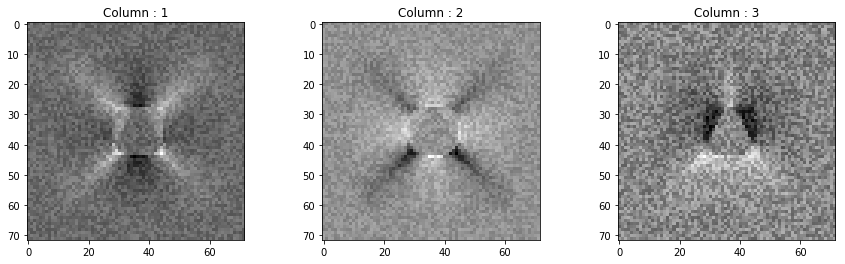

In [10]:
beta = model.get_weights()[0]
plt.figure(figsize=(15,4))
for i in range(beta.shape[1]) : 
    plt.subplot(1,3,i+1)
    plt.imshow(1 - beta[:,i].reshape(( int(np.sqrt(beta.shape[0])), int(np.sqrt(beta.shape[0])) )),cmap='gray')
    plt.title('Column : {}'.format(i+1))

We get good results because of the simplicity of the shapes to classify. The fully connected networks are not suited for image data. We'll see a more suited architecture in the next part.

## A More Difficult Classification Problem

In [11]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y = to_categorical(Y_train)
[X_test, Y_test] = generate_test_set_classification()
X_test = X_test.reshape(-1,72,72,1)
print('The data shape is : {}'.format(X_train.shape))
print('The labels shape is : {}'.format(Y.shape))


Creating data:
Done
Creating data:
Done
The data shape is : (300, 5184)
The labels shape is : (300, 3)


In this part we'll be using Convolution neural networks, that takes into account the similarity and shapes of the image pixels.

In [12]:
input_img = 72
model_2 = Sequential()
model_2.add(Conv2D(16, (3,3),input_shape=(input_img,input_img,1), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Conv2D(32, (3,3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dense(3,activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.fit(X_train.reshape(-1,72,72,1), Y, epochs=25, batch_size=16,  verbose=1)

Epoch 1/25
300/300 [==============================] - 3s 9ms/step - loss: 1.0740 - acc: 0.4333
Epoch 2/25
300/300 [==============================] - 0s 720us/step - loss: 0.9002 - acc: 0.6133
Epoch 3/25
300/300 [==============================] - 0s 743us/step - loss: 0.6897 - acc: 0.7400
Epoch 4/25
300/300 [==============================] - 0s 726us/step - loss: 0.5593 - acc: 0.7900
Epoch 5/25
300/300 [==============================] - 0s 716us/step - loss: 0.4883 - acc: 0.8600
Epoch 6/25
300/300 [==============================] - 0s 723us/step - loss: 0.3973 - acc: 0.8833
Epoch 7/25
300/300 [==============================] - 0s 733us/step - loss: 0.3164 - acc: 0.9133
Epoch 8/25
300/300 [==============================] - 0s 753us/step - loss: 0.3116 - acc: 0.8867
Epoch 9/25
300/300 [==============================] - 0s 740us/step - loss: 0.2682 - acc: 0.9267
Epoch 10/25
300/300 [==============================] - 0s 730us/step - loss: 0.2152 - acc: 0.9433
Epoch 11/25
300/300 [==========

In [13]:
loss_eval, acc_eval = model_2.evaluate(X_test, Y_test)
print('loss on test : {}'.format(loss_eval))
print('accuracy on test : {}'.format(acc_eval))

300/300 [==============================] - 0s 670us/step
loss on test : 0.8508209196726481
accuracy on test : 0.7933333333333333


You can run this next cell multiple times to see the prediction on new data.

Creating data:
Done


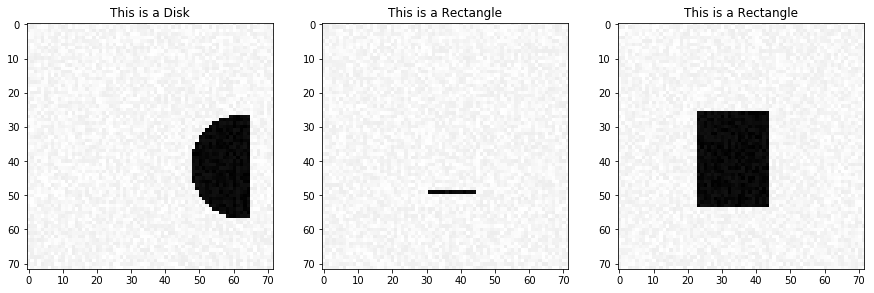

In [14]:
X_test, _ = generate_dataset_classification(3, 20, True)
X_test1 = X_test[0].reshape(1, input_img,input_img,1)
X_test2 = X_test[1].reshape(1, input_img,input_img,1)
X_test3 = X_test[2].reshape(1, input_img,input_img,1)

Y1 = model_2.predict(X_test1)
Y2 = model_2.predict(X_test2)
Y3 = model_2.predict(X_test3) 

plt.figure(figsize=((15,5)))
plt.subplot(1,3,1)
plt.imshow(X_test1.reshape(input_img,input_img),cmap='gray')
plt.title('This is a {}'.format(label_toshape[np.argmax(Y1)] ))
plt.subplot(1,3,2)
plt.imshow(X_test2.reshape(input_img,input_img),cmap='gray')
plt.title('This is a {}'.format(label_toshape[np.argmax(Y2)] ))
plt.subplot(1,3,3)
plt.imshow(X_test3.reshape(input_img,input_img),cmap='gray')
plt.title('This is a {}'.format(label_toshape[np.argmax(Y3)] ))
plt.show()

## A Regression Problem

In [15]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()


print('The data shape is : {}'.format(X_train.shape))
print('The labels shape is : {}'.format(Y_train.shape))

Creating data:
Done
Creating data:
Done
The data shape is : (1000, 5184)
The labels shape is : (1000, 6)


The labels for the data are the positions $(x,y)$ for the 3 vertices of the triangle. We're gonna sort them according to $x-y$ so the algorithm can recognize the points in the same order.

In [16]:
def sort_label(Y) : 
    p = Y.reshape(-1,3,2)
    a = np.zeros((p.shape[0],3))
    for i in range(p.shape[0]) : 
        a[i] = p[i,:,0] - p[i,:,1]
        p[i] = p[i,np.argsort(a[i])]
    return p.reshape(-1,6)

For the images, we make the values between $[-0.5 , 0.5]$, so that the gradient descent converges more easily. ( as it's initialized randomly and not only to positive values.)

In [17]:
input_img = int(np.sqrt(X_train.shape[1]))
X_train = (X_train - 0.5).reshape(-1,input_img,input_img,1)
X_test = (X_test - 0.5).reshape(-1,input_img,input_img,1)
Y = sort_label(Y_train) - 0.5
Y_test_sorted = sort_label(Y_test) - 0.5 


In [18]:
model_3 = Sequential()
model_3.add(Conv2D(8,(3,3), input_shape=(input_img,input_img,1), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Conv2D(16,(3,3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Conv2D(16,(3,3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Flatten())
model_3.add(Dense(6, activation='linear'))


optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_3.compile(loss='mean_absolute_error', optimizer='adadelta')
model_3.fit(X_train, Y, validation_data=(X_test,Y_test_sorted), epochs=100, batch_size=32,  verbose=1)

Train on 1000 samples, validate on 300 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1935 - val_loss: 0.1599
Epoch 2/100
1000/1000 [==============================] - 1s 529us/step - loss: 0.1597 - val_loss: 0.1865
Epoch 3/100
1000/1000 [==============================] - 1s 531us/step - loss: 0.1498 - val_loss: 0.1490
Epoch 4/100
1000/1000 [==============================] - 1s 512us/step - loss: 0.1356 - val_loss: 0.1277
Epoch 5/100
1000/1000 [==============================] - 1s 520us/step - loss: 0.1271 - val_loss: 0.1158
Epoch 6/100
1000/1000 [==============================] - 1s 544us/step - loss: 0.1195 - val_loss: 0.1143
Epoch 7/100
1000/1000 [==============================] - 1s 626us/step - loss: 0.1125 - val_loss: 0.1296
Epoch 8/100
1000/1000 [==============================] - 1s 526us/step - loss: 0.1079 - val_loss: 0.1109
Epoch 9/100
1000/1000 [==============================] - 1s 531us/step - loss: 0.1018 - val_loss: 0.1015
Epoch 10/1

Epoch 78/100
1000/1000 [==============================] - 1s 515us/step - loss: 0.0421 - val_loss: 0.0775
Epoch 79/100
1000/1000 [==============================] - 1s 625us/step - loss: 0.0412 - val_loss: 0.0718
Epoch 80/100
1000/1000 [==============================] - 1s 586us/step - loss: 0.0422 - val_loss: 0.0737
Epoch 81/100
1000/1000 [==============================] - 1s 635us/step - loss: 0.0416 - val_loss: 0.0727
Epoch 82/100
1000/1000 [==============================] - 1s 582us/step - loss: 0.0405 - val_loss: 0.0724
Epoch 83/100
1000/1000 [==============================] - 1s 612us/step - loss: 0.0410 - val_loss: 0.0735
Epoch 84/100
1000/1000 [==============================] - 1s 543us/step - loss: 0.0400 - val_loss: 0.0758
Epoch 85/100
1000/1000 [==============================] - 1s 574us/step - loss: 0.0406 - val_loss: 0.0753
Epoch 86/100
1000/1000 [==============================] - 1s 550us/step - loss: 0.0401 - val_loss: 0.0755
Epoch 87/100
1000/1000 [======================

In [19]:
print('loss on test : {}'.format(model_3.evaluate(X_test, Y_test_sorted)))

300/300 [==============================] - 0s 250us/step
loss on test : 0.0715543441971143


real output


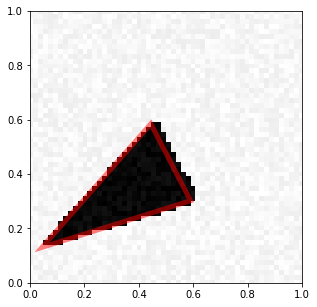

predicted output


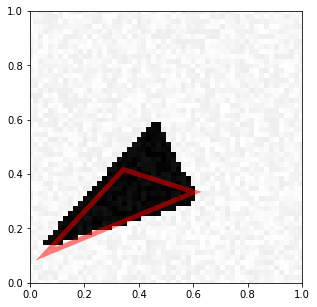

In [20]:
Y_pred = model_3.predict(X_test)
 
idx = np.random.randint(0,299)
print('real output')
visualize_prediction(X_test[idx], Y_test[idx])
print('predicted output')
visualize_prediction(X_test[idx], Y_pred[idx]+0.5)

real output


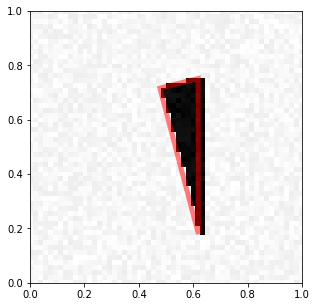

predicted output


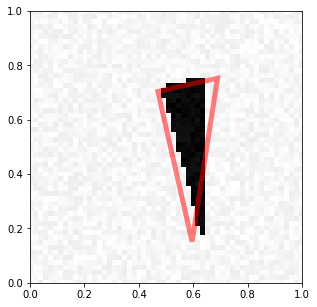

In [21]:
Y_pred = model_3.predict(X_train)
idx = np.random.randint(0,299)
print('real output')
visualize_prediction(X_train[idx], Y_train[idx])
print('predicted output')
visualize_prediction(X_train[idx], Y_pred[idx]+0.5)


## Image Denoising

We generate the same picture twice, the first one with random noise between $[20,50]$.

In [22]:
def generate_dataset_hourglass(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
#         if i % 100 == 0:
#             print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
#             Y[i] = X[i].copy() + noise * np.random.random(X[i].size)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
#             Y[i] = X[i].copy() + noise * np.random.random(X[i].size)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
#             Y[i] = X[i].copy() + noise * np.random.random(X[i].size)
    noise = np.random.randint(20,50)*np.random.random(X[0].size)
    Y = (X.copy() + noise) / (255 + 2 * noise)
    X = X/255
    print('Done')
    return [Y, X]

In [23]:
[X_train, Y_train] = generate_dataset_hourglass(1000)
[X_test, Y_test] = generate_dataset_hourglass(300)

print('The data shape is : {}'.format(X_train.shape))
print('The labels shape is : {}'.format(Y_train.shape))

Creating data:
Done
Creating data:
Done
The data shape is : (1000, 5184)
The labels shape is : (1000, 5184)


Plotting the noise free image and the noised one. 

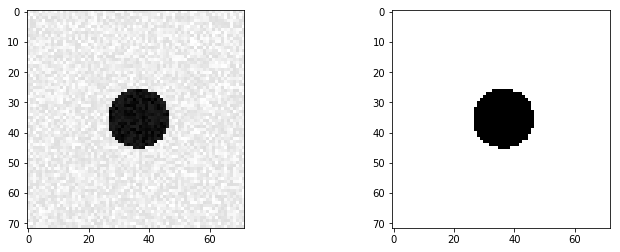

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
idx = np.random.randint(X_train.shape[0])
plt.imshow(X_train[idx].reshape(72,72), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(Y_train[idx].reshape(72,72), cmap='gray')

Preparing data for the Neural Network 

In [25]:
X_train = X_train.reshape(-1,72,72,1)
Y_train = Y_train.reshape(-1,72,72,1)
X_test = X_test.reshape(-1,72,72,1)
Y_test = Y_test.reshape(-1,72,72,1)

Creating a Hourglass autoencoder : 

In [26]:
from keras.layers import UpSampling2D, Conv2DTranspose

AE = Sequential()
AE.add(Conv2D(8,(3,3), input_shape=(input_img,input_img,1), activation='relu', padding='same'))
AE.add(MaxPooling2D(pool_size=(2,2), padding='same'))
AE.add(Conv2D(16,(3,3), activation='relu', padding='same'))
AE.add(MaxPooling2D(pool_size=(2,2), padding='same'))
AE.add(Conv2D(32,(3,3), activation='relu', padding='same'))
AE.add(MaxPooling2D(pool_size=(2,2), padding='same'))
AE.add(Conv2D(32,(3,3), activation='relu', padding='same'))
AE.add(UpSampling2D(size=(2,2)))
AE.add(Conv2D(16,(3,3), activation='relu', padding='same'))
AE.add(UpSampling2D(size=(2,2)))
AE.add(Conv2D(8,(3,3), activation='relu', padding='same'))
AE.add(UpSampling2D(size=(2,2)))
AE.add(Conv2D(1,(3,3), activation='sigmoid', padding='same'))



In [27]:
AE.compile(loss='binary_crossentropy', optimizer='adadelta')
AE.fit(X_train,  Y_train , validation_data=(X_test,Y_test), epochs=50, batch_size=32,  verbose=1)

Train on 1000 samples, validate on 300 samples
Epoch 1/50
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4781 - val_loss: 0.4171
Epoch 2/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1995 - val_loss: 0.1225
Epoch 3/50
1000/1000 [==============================] - 1s 960us/step - loss: 0.0920 - val_loss: 0.0572
Epoch 4/50
1000/1000 [==============================] - 1s 963us/step - loss: 0.0682 - val_loss: 0.0716
Epoch 5/50
1000/1000 [==============================] - 1s 967us/step - loss: 0.0555 - val_loss: 0.0389
Epoch 6/50
1000/1000 [==============================] - 1s 983us/step - loss: 0.0529 - val_loss: 0.0339
Epoch 7/50
1000/1000 [==============================] - 1s 963us/step - loss: 0.0479 - val_loss: 0.0429
Epoch 8/50
1000/1000 [==============================] - 1s 977us/step - loss: 0.0380 - val_loss: 0.0522
Epoch 9/50
1000/1000 [==============================] - 1s 959us/step - loss: 0.0400 - val_loss: 0.0425
Epoch 10/50
1000/1000

<function matplotlib.pyplot.show(*args, **kw)>

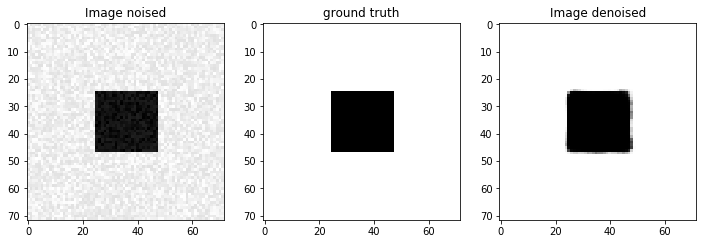

In [28]:
Y_pred = AE.predict(X_test)



idx = np.random.randint(X_test.shape[0])
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X_test[idx].reshape(72,72), cmap='gray')
plt.title('Image noised')
plt.subplot(1,3,2)
plt.imshow(Y_test[idx].reshape(72,72), cmap='gray')
plt.title('ground truth')
plt.subplot(1,3,3)
plt.imshow(Y_pred[idx].reshape(72,72), cmap='gray')
plt.title('Image denoised')
plt.show